In [2]:
import gensim
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder

In [3]:
df = pd.read_csv("../crimeBB/crimebb_preprocessed.csv")
# df = pd.read_csv("../crimeBB/CVE_CrimeBB - cve_crimebb.csv")
df.dropna(subset=['Tags0'], inplace=True) # drop rows without labels
df.CVE = df.CVE.str.lower()
df.Content = df.Content.astype(str).str.lower()
df = df[~df.Tags0.isin(['russian', '\\', 'others', 'doubt', 'error', 'market'])]
df.rename(columns={'Tags0':'exploitability'}, inplace=True)
df.reset_index(inplace=True)
df.head()

,index,Unnamed: 0,Unnamed: 0.1,CVE,IdPost,Time,Likes,Content,obs,exploitability,Tags1,Tags2
0,0,0,1550.0,cve-2012-0500,7345.0,2012-03-06 00:28:00-03:00,NaN,binary analysis of oracle java cve: 2012-0500 ...,NaN,weaponization,NaN,NaN
1,2,2,1263.0,cve-2013-0431,32622237.0,2013-05-13 22:24:00-03:00,NaN,ok i've made threads about this before and non...,NaN,exploitation,NaN,NaN
2,4,4,1223.0,cve-2017-0199,56090050.0,2017-10-18 08:34:00-02:00,NaN,***citing***[https://hackforums.net/showthread...,Trillium,exploitation,NaN,NaN
3,5,5,1617.0,cve-2015-0313,45426930.0,2015-03-27 00:01:00-03:00,NaN,has cve means not 0day\nif you're talking abou...,NaN,weaponization,NaN,NaN
4,6,6,526.0,cve-2016-5195,53854632.0,2017-01-19 02:07:00-02:00,NaN,how to get root access to any server\n\nhello ...,tutorial,PoC,exploitation,NaN


In [29]:
def ApplyDoc2Vec(model, df):
    docvecs = [model.infer_vector(word_tokenize(doc)) for doc in df.Content]
    X = hstack((docvecs, pd.DataFrame(df.nCVEs), pd.DataFrame(df.nLinks),
                pd.DataFrame(df.AuthorNumPosts), pd.DataFrame(df.ThreadNumPosts)))
    y = df.exploitability
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
    clf = SVC(gamma='auto')

    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    print(accuracy_score(y_test, predicted))
    print(cross_val_score(clf, X, y, cv=5).mean())
#     print("F1 score: ", f1_score(y_test, predicted))
#     print("ROC score: ", roc_auc_score(y_test, predicted))

In [26]:
posts.columns

Index(['IdPost', 'Author', 'Timestamp', 'Content', 'AuthorNumPosts',
       'AuthorReputation', 'CitedPost', 'AuthorName', 'IdThread',
       'ThreadAuthor', 'ThreadAuthorName', 'Board', 'Heading',
       'ThreadNumPosts', 'index', 'Unnamed: 0', 'Unnamed: 0.1', 'CVE', 'Time',
       'Likes', 'Content_y', 'obs', 'exploitability', 'Tags1', 'Tags2',
       'nLinks', 'nCVEs'],
      dtype='object')

# Doc2Vec training only on sub dataset

In [22]:
df_full = pd.read_csv("all_posts_with_cve.csv", header=0)
posts = pd.merge(df_full, df, on=['IdPost'])
posts.rename(columns={'Tags0': 'exploitability', 'NumPosts': 'ThreadNumPosts', 'Content_x':'Content'}, inplace=True)
posts.shape

(1954, 27)

In [28]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(posts.Content)]
model = Doc2Vec(documents, vector_size=300, epochs=5, min_count=2)
ApplyDoc2Vec(model, posts)

KeyboardInterrupt: 

# Using model trained on whole Hackforums

In [40]:
model = Doc2Vec.load("hackforums_vecsize50")
docvecs = [model.infer_vector(word_tokenize(doc)) for doc in df.Content]
# X = hstack((docvecs, pd.DataFrame(df.nCVEs), pd.DataFrame(df.nLinks),
#             pd.DataFrame(df.ScanKeywords), pd.DataFrame(df.cvss_score)))
X = hstack((docvecs, pd.DataFrame(df.nCVEs), pd.DataFrame(df.nLinks)))
y = df.Tags0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
clf = SVC(gamma='auto')

clf.fit(X_train, y_train)
print(accuracy_score(y_test, clf.predict(X_test)))
print(cross_val_score(clf, X, y, cv=5).mean())

0.805045871559633
0.763914028061858


In [20]:
df = df[(lbl.inverse_transform(df.Tags0) == 'exploitation') | (lbl.inverse_transform(df.Tags0) == 'PoC')]

/home/mateus/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/mateus/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Training a much more simple Doc2Vec Neural Network with posts citing CVEs and posts that don't but respond to a Thread that does

In [8]:
cves_heading = pd.read_csv("posts_without_cve_but_heading_with_it.csv")
cves_posts = pd.read_csv("posts_cve_but_not_in_heading.csv")
cves_both = pd.read_csv("posts_cve_both.csv")
posts = pd.concat([cves_heading, cves_posts, cves_both])
posts.Content = posts.Content.map(preprocessLine)

In [ ]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(posts.Content)]
model = Doc2Vec(documents, vector_size=100, epochs=5, min_count=2)

In [29]:
ApplyDoc2Vec(model, df)

0.9154411764705882
0.8888291569190201
F1 score:  0.8588957055214723
ROC score:  0.9292007985131134


In [11]:
boards = pd.read_csv("boards.csv")
boards.head(30)

,Title,count
0,Pentesting and Forensics,560
1,Premium Tools and Programs,433
2,Website and Forum Hacking,331
3,Hacking Tools and Programs,249
4,Beginner Hacking,219
5,Premium Sellers Section,210
6,"Botnets, IRC Bots, and Zombies",161
7,Secondary Sellers Market,91
8,News and Happenings,75
9,Remote Administration Tools,75


/home/mateus/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


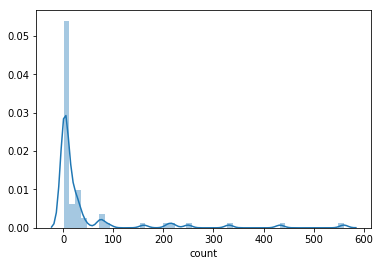

In [21]:
import seaborn as sns
sns.distplot(boards['count'])

In [42]:
boards.Title.values

array(['Pentesting and Forensics', 'Premium Tools and Programs',
       'Website and Forum Hacking', 'Hacking Tools and Programs',
       'Beginner Hacking', 'Premium Sellers Section',
       'Botnets, IRC Bots, and Zombies', 'Secondary Sellers Market',
       'News and Happenings', 'Remote Administration Tools',
       'Hacking Tutorials',
       'White Hat Malware, Virus, and Rat Removal Help',
       'Computer Protection and Security Alerts', 'Requests for Hacking',
       'Java Language, JVM, and the JRE', 'Buyers Bay', 'PHP Development',
       'Python', 'The Lounge', 'Partnerships, Hiring, and Personnel',
       'SQL Injection Attacks', 'Linux, FreeBSD, and Unix Flavors',
       'Wifi WPA WEP Bluetooth 4G LTE Wireless Hacking',
       'Worms, Malware, and Viruses', 'Marketplace Discussions',
       'Decompiling, Reverse Engineering, Disassembly, and Debugging',
       'C/C++/Obj-C Programming', 'Service Offerings', 'Video Tutorials',
       'Griefing', 'Cryptography and Encryptio